In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)
%config InlineBackend.figure_format = 'png' 


from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [18]:
#для начала, немного поколдуем над данными (вытащим из второго датасета заголовки для первого)
df=pd.read_csv('Data/cars2.csv')
head=[i[0] for i in pd.read_csv('Data/cars2head.csv',header=-1).values]
df.columns=head

In [19]:
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 26 columns):
symboling            204 non-null int64
normalized-losses    204 non-null object
make                 204 non-null object
fuel-type            204 non-null object
aspiration           204 non-null object
num-of-doors         204 non-null object
body-style           204 non-null object
drive-wheels         204 non-null object
engine-location      204 non-null object
wheel-base           204 non-null float64
length               204 non-null float64
width                204 non-null float64
height               204 non-null float64
curb-weight          204 non-null int64
engine-type          204 non-null object
num-of-cylinders     204 non-null object
engine-size          204 non-null int64
fuel-system          204 non-null object
bore                 204 non-null object
stroke               204 non-null object
compression-ratio    204 non-null float64
horsepower           204 non-nul

# Что можно сделать?
1) Предсказать годовой убыток от страховки в зависимости от характеристик модели (по умолчанию, этот показатель зависит от следующих фич: wheel-base, length, width, height, engine-size, horsepower, city-mpg, highway-mpg)

2) Предсказать какой-нибудь значимый для потребителя параметр в зависимости от характеристик - например, потребление топлива (в городе или на шоссе) или цену.

3) Предсказать относительную безопасность автомобиля (для текущего ценового сегмента) в зависимости от его характеристик

Займемся первым случаем. Для начала, нам нужно немного обработать наш датасет

# Варим фичи

In [21]:
#возьмем нужные нам фичи (характеристику модели, производитель и потери от страховки)
df1=df[['wheel-base','length','width','height','engine-size','horsepower','city-mpg','highway-mpg','normalized-losses']]
df1.head()

,wheel-base,length,width,height,engine-size,horsepower,city-mpg,highway-mpg,normalized-losses
0,88.6,168.8,64.1,48.8,130,111,21,27,?
1,94.5,171.2,65.5,52.4,152,154,19,26,?
2,99.8,176.6,66.2,54.3,109,102,24,30,164
3,99.4,176.6,66.4,54.3,136,115,18,22,164
4,99.8,177.3,66.3,53.1,136,110,19,25,?


Дальше попробуем заменить знаки вопроса на средние значения, но не по всей выборке, а сгруппированные по марке автомобиля

In [22]:
df1=df1.replace({'?':'NaN'}).astype('float64')

In [23]:
df2=pd.concat([df['make'],df1],axis=1)

In [24]:
head=df2.loc[:,'wheel-base':].columns

In [25]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 10 columns):
make                 204 non-null object
wheel-base           204 non-null float64
length               204 non-null float64
width                204 non-null float64
height               204 non-null float64
engine-size          204 non-null float64
horsepower           202 non-null float64
city-mpg             204 non-null float64
highway-mpg          204 non-null float64
normalized-losses    164 non-null float64
dtypes: float64(9), object(1)
memory usage: 16.0+ KB


посмотрим, можно ли вообще так сделать - вдруг у каких-то марок отсутствуют значения тех или иных признаков во всех наблюдениях

In [10]:
df2.groupby('make').mean()

,wheel-base,length,width,height,engine-size,horsepower,city-mpg,highway-mpg,normalized-losses
make,,,,,,,,,
alfa-romero,91.550000,170.000000,64.800000,50.600000,141.000000,132.500000,20.000000,26.500000,NaN
audi,102.271429,183.828571,68.714286,54.428571,130.714286,121.000000,18.857143,24.142857,161.000000
bmw,103.162500,184.500000,66.475000,54.825000,166.875000,138.875000,19.375000,25.375000,190.000000
chevrolet,92.466667,151.933333,62.500000,52.400000,80.333333,62.666667,41.000000,46.333333,100.000000
dodge,95.011111,160.988889,64.166667,51.644444,102.666667,86.333333,28.000000,34.111111,133.444444
honda,94.330769,160.769231,64.384615,53.238462,99.307692,80.230769,30.384615,35.461538,103.000000
isuzu,94.825000,163.775000,63.550000,52.225000,102.500000,77.000000,31.000000,36.000000,NaN
jaguar,109.333333,196.966667,69.933333,51.133333,280.666667,204.666667,14.333333,18.333333,145.000000
mazda,97.017647,170.805882,65.588235,53.358824,103.000000,85.529412,25.705882,31.941176,123.933333


И действительно - у всех автомобилей четырех марок не задан параметр normalized-losses (а у "Рено" еще и не задан параметр "horsepower"). Нет никакого смысла присваивать этому параметру среднее значение - мы просто выбросим эти наблюдения из выборки 

In [11]:
listofokcars=df2[['make']+['normalized-losses']].groupby('make').mean().reset_index()
listofokcars=np.array(listofokcars[listofokcars['normalized-losses']>0]['make'])
listofokcars

array(['audi', 'bmw', 'chevrolet', 'dodge', 'honda', 'jaguar', 'mazda',
       'mercedes-benz', 'mitsubishi', 'nissan', 'peugot', 'plymouth',
       'porsche', 'saab', 'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [12]:
df2=df2[df2['make'].isin(listofokcars)]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 2 to 203
Data columns (total 10 columns):
make                 195 non-null object
wheel-base           195 non-null float64
length               195 non-null float64
width                195 non-null float64
height               195 non-null float64
engine-size          195 non-null float64
horsepower           195 non-null float64
city-mpg             195 non-null float64
highway-mpg          195 non-null float64
normalized-losses    164 non-null float64
dtypes: float64(9), object(1)
memory usage: 16.8+ KB


В итоге мы все равно получили часть строчек, у которых искомый признак - "normalized losses" - не заполнен. С другой стороны, нам не пришлось усреднять другие признаки у наблюдений - у остальных фичей нет пустых значений. Заполнение искомого признака усредненным значением нам ничего не даст, поэтому давайте выбросим эти наблюдения тоже.

In [48]:
df2.dropna(inplace = True)

In [50]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164 entries, 2 to 203
Data columns (total 10 columns):
make                 164 non-null object
wheel-base           164 non-null float64
length               164 non-null float64
width                164 non-null float64
height               164 non-null float64
engine-size          164 non-null float64
horsepower           164 non-null float64
city-mpg             164 non-null float64
highway-mpg          164 non-null float64
normalized-losses    164 non-null float64
dtypes: float64(9), object(1)
memory usage: 14.1+ KB


Все, теперь мы получили чистый датасет (хоть количество наблюдений и сократилось примерно на четверть)

Если честно, я сначала этого не увидел (того, что эти признаки относительно чистые) и все равно все заполнил импутером, так что оставлю этот кусок кода здесь, все-таки это тестовое задание (то есть так бы я сделал, если бы у некоторых наблюдений отсутствовали признаки - заполнил бы средним по марке машины)

In [ ]:
"""
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)
"""

In [ ]:
"""
df2_imputed=pd.DataFrame(columns=head)
for x in pd.Series.unique(df2['make']):
    y=df2[df2['make']==x].loc[:,'wheel-base':]
    imputer.fit(y)
    y=pd.DataFrame(imputer.transform(y),columns=head)
    df2_imputed=pd.concat([df2_imputed, y])
"""

In [53]:
"""
df2_imputed.reset_index(inplace=True)
df2_imputed.drop('index',axis=1,inplace=True)
df2_imputed.head()
"""

"\ndf2_imputed.reset_index(inplace=True)\ndf2_imputed.drop('index',axis=1,inplace=True)\ndf2_imputed.head()\n"

In [56]:
df2.drop('make', axis =1, inplace=True)

Марка машины нам больше не понадобится

In [57]:
#посмотрим, как вообще выглядит распределение наших характеристик
trace0 = go.Scatter(x=df2.index, y=df2['wheel-base'], name='Wheel base')
trace1 = go.Scatter(x=df2.index, y=df2['length'],name='Length')
trace2 = go.Scatter(x=df2.index, y=df2['width'],name='Width')
trace3 = go.Scatter(x=df2.index, y=df2['height'],name='Height')
trace4 = go.Scatter(x=df2.index, y=df2['engine-size'],name='Engine size')
trace5 = go.Scatter(x=df2.index, y=df2['horsepower'],name='Horse power')
trace6 = go.Scatter(x=df2.index, y=df2['highway-mpg'],name='Highway mpg')
trace7 = go.Scatter(x=df2.index, y=df2['city-mpg'],name='City mpg')
trace8 = go.Scatter(x=df2.index, y=df2['normalized-losses'],name='Normalized losses')

data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8]
layout = {'title': 'First case params'}
fig = go.Figure(data=data, layout=layout)
iplot(fig)

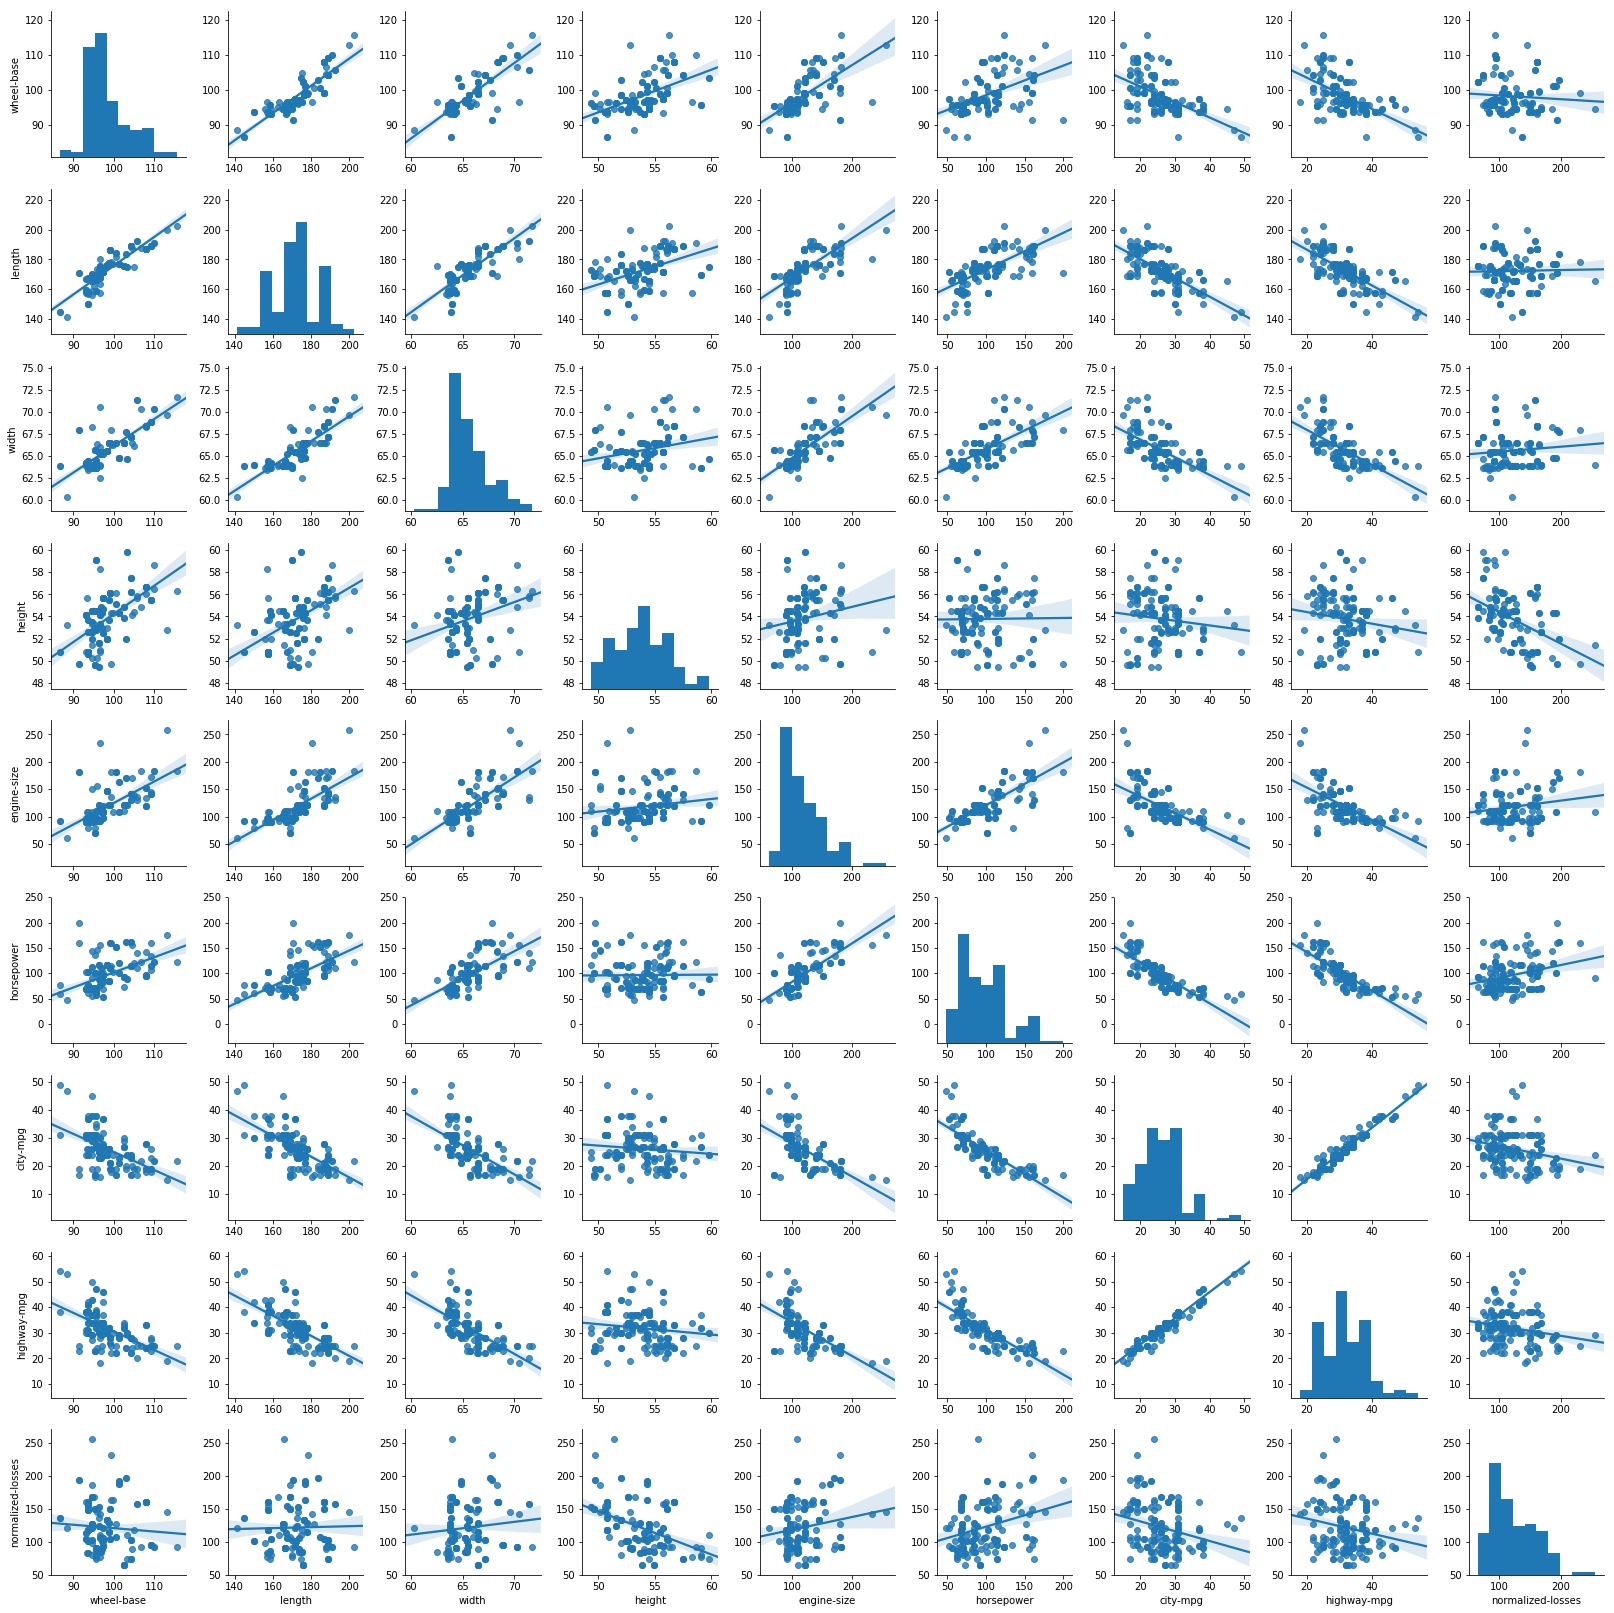

In [58]:
#как они взаимодействуют между собой (и как каждая из них взимодействует с убытками от страховки)
sns_plot = sns.pairplot(df2, kind = "reg")

Можно увидеть хорошую корреляцию у многих фичей (примерно то же мы видели на линейном графике), но сами потери связаны с характеристиками не слишком явно (самая нижняя строка). Так как все показатели у нас порядковые (и результатом не является категоризация), то здесь будет использована регрессионная предсказательная модель.

Сначала попробуем сделать кластеризацию, чтобы немного облегчить себе задачу в будущем

In [59]:
y=df2['normalized-losses'] #соберем признак, который мы будем предсказывать, в одном месте
df2.drop('normalized-losses', axis=1, inplace=True)

In [60]:
head=df2.columns

In [61]:
from sklearn.decomposition import PCA

In [62]:
pca = PCA(n_components=2)

In [63]:
ppl = pca.fit_transform(df2)

In [64]:
pca.explained_variance_ratio_.sum() #ага, 2 фичи объясняют 95% всех различий

0.95237759638674147

Text(0.5,1,'Параметры автомобиля')

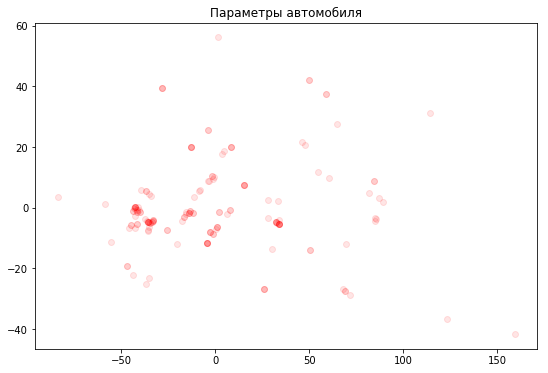

In [66]:
plt.plot(ppl[:,0], ppl[:,1], 'ro', alpha=0.1)
plt.title('Параметры автомобиля')

Похоже, кластеризация мало что даст, да и наблюдений у нас очень мало. Попробуем собрать регрессию и посмотрим, что получится

# Собираем предсказательную модель

In [67]:
#для начала, нормируем значения, чтобы сопоставлять разные фичи
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df2)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [68]:
df2_scaled = scaler.transform(df2)
df2_scaled = pd.DataFrame(df2_scaled, columns=head)

In [69]:
df2_scaled.head()

,wheel-base,length,width,height,engine-size,horsepower,city-mpg,highway-mpg
0,0.320493,0.383168,0.313600,0.224929,-0.290804,0.191079,-0.367371,-0.284483
1,0.242131,0.383168,0.417921,0.224929,0.585764,0.619899,-1.339126,-1.516302
2,1.495911,1.797561,3.025951,0.824042,0.585764,0.454968,-1.177167,-1.054370
3,1.495911,1.797561,3.025951,0.909630,0.423437,1.444554,-1.501085,-1.824257
4,0.594757,0.400738,-0.416649,0.224929,-0.323269,0.158092,-0.529330,-0.438460


Разделим выборку на две: обучающую и тестирующую

In [70]:
from sklearn.model_selection import train_test_split

In [174]:
X_train, X_val, y_train, y_val = train_test_split(df2_scaled, np.array(y), test_size=0.2)

У линейной регрессии почти нет параметров, которые можно перебирать в рамках кросс-валидации, но давайте загоним fit_intercept и normalize и посмотрим, как будет вести себя наша модель

In [175]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

In [176]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}

In [177]:
gridsearch = GridSearchCV(LinearRegression(),parameters, scoring='r2', cv=5) #возьмем количество разибений равным пяти, тк наша выборка получилась совсем небольшой

In [178]:
%%time
gridsearch.fit(X_train, y_train)

CPU times: user 71.2 ms, sys: 4.95 ms, total: 76.1 ms
Wall time: 73.4 ms


GridSearchCV(cv=5, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [179]:
sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning:

The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20



[mean: 0.20100, std: 0.12319, params: {'fit_intercept': True, 'normalize': False},
 mean: 0.20100, std: 0.12319, params: {'fit_intercept': True, 'normalize': True},
 mean: -12.92031, std: 2.81869, params: {'fit_intercept': False, 'normalize': True},
 mean: -12.92031, std: 2.81869, params: {'fit_intercept': False, 'normalize': False}]

Тут никаких сюрпризов нет

In [180]:
gridsearch.best_params_

{'fit_intercept': True, 'normalize': False}

In [181]:
from sklearn.metrics import accuracy_score

In [182]:
model = LinearRegression(fit_intercept=True)

In [183]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [184]:
y_val_pred = model.predict(X_val)

можно посмотреть наиболее значимые в одну или другую сторону фичи:

In [185]:
["{:10} {:.3f}".format(x, y) for y, x in sorted(zip(model.coef_,X_val.columns))]

['city-mpg   -23.813',
 'height     -19.892',
 'horsepower -3.921',
 'wheel-base -2.010',
 'engine-size 1.789',
 'width      4.094',
 'length     4.711',
 'highway-mpg 14.318']

# Оцениваем нашу модель

Визуально оценим, насколько наше предсказание попадает. Идеальный случай - прямая под 45 градусов

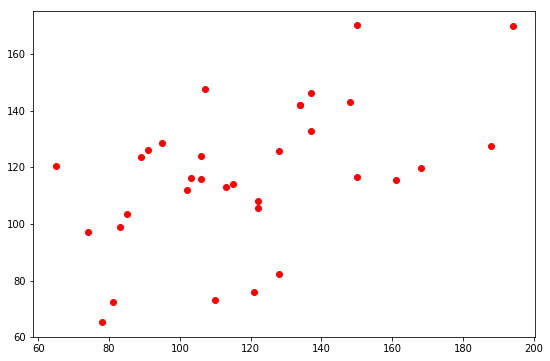

In [186]:
plt.plot(y_val,y_val_pred, 'ro')

Сделаем то же самое, но чуть красивее

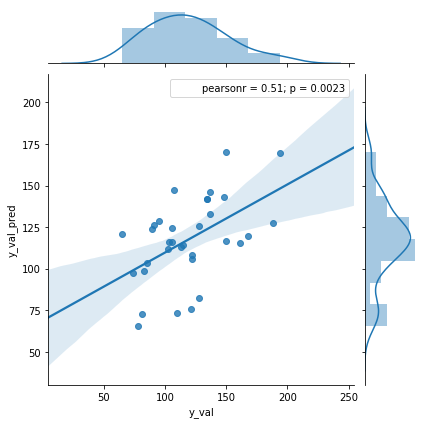

In [187]:
sns.jointplot(x='y_val', y='y_val_pred', 
              data=pd.DataFrame({'y_val':y_val.tolist(), 'y_val_pred':y_val_pred.tolist()}), kind='reg');

P-value меньше 0,05, значит, между тестовой и предсказанной выборками нет значимых различий. Это хороший звоночек - модель научена нормально.
Посмотрим, в какую сторону и как мы ошибаемся

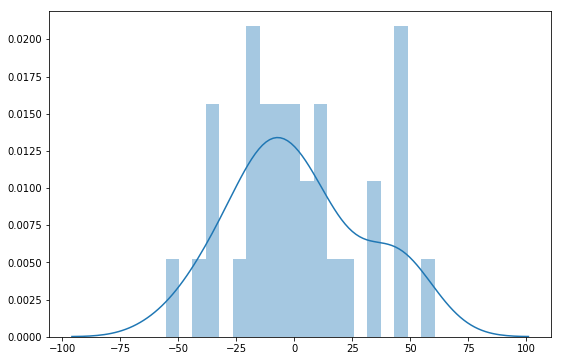

In [209]:
sns.distplot(y_val-y_val_pred,bins=20)

# Считаем среднеквадратичную ошибку

In [210]:
from sklearn.metrics import mean_squared_error

In [211]:
#посмотрим, как и где мы ошибались
y_val-y_val_pred

array([ 12.59807239,  13.92854252, -18.16151219,  36.79471236,
       -34.76821195, -13.20980638, -23.14986452,  16.33041131,
         2.14060579, -33.5847674 ,   4.77363353, -40.60379467,
       -20.07516377, -55.57567516,   0.82507629, -10.07528697,
       -15.79340579,   8.54776326,  -8.10111916,  45.15881289,
        -9.09887717,  48.18022577, -18.36579747, -35.24818087,
        60.48006531,  -0.0861393 ,   4.06842544,  45.50432235,
        -8.10111916,  45.3201615 ,  -9.77300827,  33.52783986,  24.15746421])

In [212]:
mse=mean_squared_error(y_val,y_val_pred) 

In [213]:
print('mse', mse)
print('sqrt(mse)', mse**0.5) #считаем стандартную ошибку
print('avg_error', np.mean(abs(y_val-y_val_pred))) #считаем среднюю ошибку

mse 809.068721991
sqrt(mse) 28.4441333493
avg_error 22.9123595448


То есть в среднем мы ошибаемся почти на 23 единицы (в ту или другую сторону), при этом стандартная ошибка - корень из среднеквадратичной ошибки - равна 28. Наша задача - свести оба эти числа к минимуму (идеальная ситуация - к нулю). Но как?

# Что можно сделать

1) Увеличить обучающую выборку

2) Сделать выборку более чистой, т.е. минимизировать количество пропусков (и тем более в искомом признаке)

# Что бы я сделал

Будь у меня больше времени и лучший датасет

Взял бы больше фичей - возможно, среди тех, которые мы проигнорировали, могли оказаться значимые фичи, которые опосредованно влияют на искомый признак. Все это надо крутить и проверять - но для этого нужно чистить и приводить в порядок каждый признак, а потом поочередно смотреть, как он будет влиять на итоговую модель. Скорее всего, более насыщенный датасет можно было бы кластеризовать, и потом итоги кластеризации можно было бы применить как признак. Я бы еще подумал о том, как применить дерево решений параллельно с регрессией для увеличения точности модели - например, можно сгруппировать искомый признак, предсказывать сначала группу, а потом, используя информацию о группе как еще одну фичу, предсказать значение. 